
# Задание:
----

<br>

Вам предоставлен анонимизированные результаты **реального A/B тестирования**, проходившего когда-то в нашем отделе (`ab_test_ensembles.csv`). В тесте было два варианта работы сервиса - `standard` и `svm_ensemble_v_1_22`, где работали несколько моделей классификации для целей сервиса.

<br>


------
Вам, как специалистам по машинному обучению предстоит ответить на **2 главных вопроса:**

1. Стоит ли нам оставить старый вариант работы сервиса или заменить его на вариант работы с моделями классификации (используем всю выборку 200к+ пользователей).
2. Кроме того, посчитайте вывод для типа пользователей (`user_type`). Стоит ли для новых (старых) пользователей оставить старый (новый) вариант работы сервиса.


<br>

Для того, чтобы освежить в памяти процесс тестирования статистических гипотез, непомню, что тестирование состоит из следующих частей:
1. Дизайн эксперимента.
2. Подготовка и запуск эксперимента.
3. Сбор данных и аналитика полученных данных.
4. Визуализация результатов тестирования.
5. Тестирование гипотез.
6. Вывод и интерпритация результатов.

-----

#### Критерии оценки задания:

1. **Первое, что будет проверяться - вывод полученных результатов**, в случае если выводы сделаны не правильно, задание считается проваленным и на этом этап проверки заканчивается (пропускаются этапы код-ревью, оформления и визуализации, качество кода).
2. В случае если результаты и интерпритация результатов оказались верны, проводится код-ревью и проверка этапа визуализаций, поиск проблемных точек, точек роста.
3. **Максимальный балл** который можно получить, выполнив текущее задание: **2 балла за 1 вопрос, 2 балла за 2 вопрос и 1 балл за эффективный и аккуратный код.


Удачи, примените все свои навыки, которые вам доступны на данный момент и покажите на что вы способны!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('ab_test_ensembles.csv')

In [3]:
df.columns

Index(['user_id', 'timestamp', 'group', 'variants', 'converted', 'location',
       'age_group', 'user_type'],
      dtype='object')

In [4]:
df.dtypes

user_id      object
timestamp    object
group        object
variants     object
converted     int64
location     object
age_group    object
user_type    object
dtype: object

In [5]:
df.head()

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


In [7]:
df.isnull().sum()

user_id      0
timestamp    0
group        0
variants     0
converted    0
location     0
age_group    0
user_type    0
dtype: int64

In [8]:
df.variants.value_counts()

variants
standard               147239
svm_ensemble_v_1_22    147239
Name: count, dtype: int64

In [9]:
df.nunique()

user_id      294478
timestamp    294478
group             2
variants          2
converted         2
location          1
age_group         6
user_type         2
dtype: int64

In [10]:
df.converted.value_counts()

converted
0    259241
1     35237
Name: count, dtype: int64

In [11]:
convert_rates = [
    len(df[(df['converted'] == 1) & (df['variants'] == 'standard')]) / len(df[df['variants'] == 'standard']),
    len(df[(df['converted'] == 1) & (df['variants'] == 'svm_ensemble_v_1_22')]) / len(df[df['variants'] == 'svm_ensemble_v_1_22'])
]


In [12]:
convert_rates

[0.12047759085568362, 0.11884079625642663]

In [13]:
df['variants'] = np.where(df['variants']== 'standard', 'A','B')

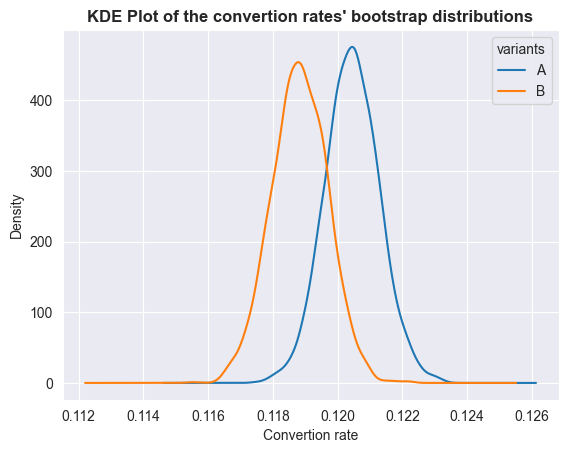

In [14]:
n = 2000

bootstrap_sum = pd.DataFrame([df.sample(frac=1, replace=True).groupby('variants')['converted'].mean() for i in range(n)])

bootstrap_sum.plot.kde()
sns.set(rc={'figure.figsize':(18,5)})
plt.title("KDE Plot of the convertion rates' bootstrap distributions", fontweight="bold")
plt.xlabel("Convertion rate")
plt.show()

In [15]:
df['group'].value_counts()

group
treatment    147276
control      147202
Name: count, dtype: int64

In [16]:
bootstrap_sum['diff_mean'] = bootstrap_sum['B'] - bootstrap_sum['A']
mean_pos_count = len(bootstrap_sum[bootstrap_sum['diff_mean'] > 0])
p_mean_diff = mean_pos_count/n
p_mean_diff

0.09

In [17]:
from scipy.stats import norm
alpha = 0.05
z_mean = np.mean(bootstrap_sum['B'])- np.mean(bootstrap_sum['A'])
z_sigma = np.sqrt((np.var(bootstrap_sum['B'])/n + np.var(bootstrap_sum['A'])/n))
print("Mean of (verison B - verison A):\t\t\t", z_mean)
print("Standard Error of (verison B -  verison A):\t", z_sigma)
print("CI of (verison B - verison A):\t\t\t\t", [z_mean - norm.ppf(1-alpha/2)*z_sigma, z_mean + norm.ppf(1-alpha/2)*z_sigma] )

Mean of (verison B - verison A):			 -0.0016199477411772967
Standard Error of (verison B -  verison A):	 2.6914066044223062e-05
CI of (verison B - verison A):				 [-0.0016726983413015062, -0.0015671971410530872]


In [18]:
CI = np.percentile(bootstrap_sum['diff_mean'], [2.5, 97.5])
CI

array([-0.0040557 ,  0.00080209])

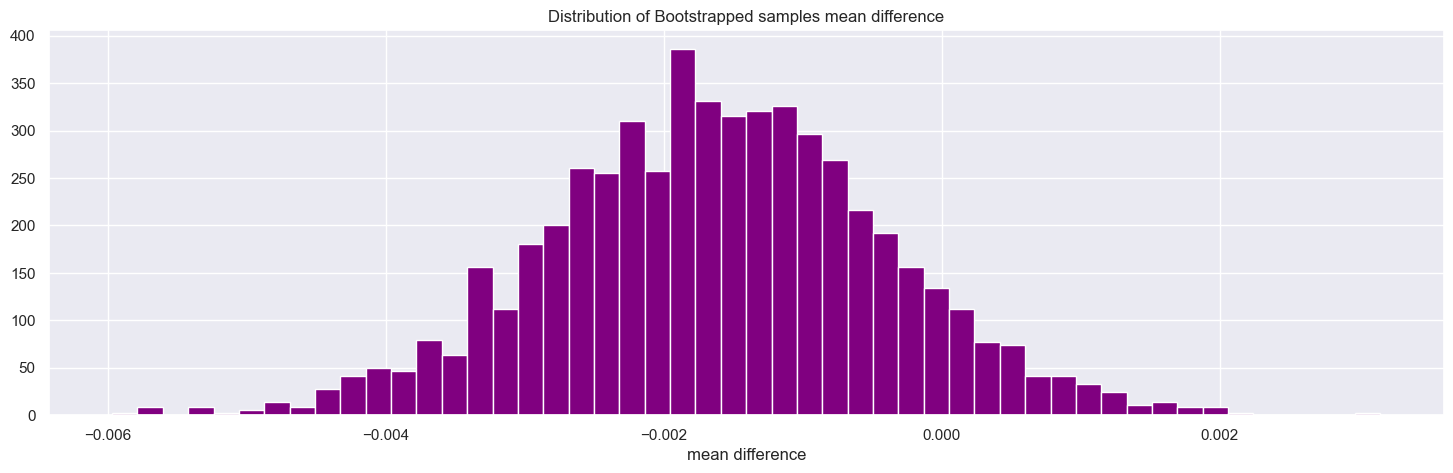

In [19]:
counts,bins,ignored = plt.hist(bootstrap_sum['diff_mean'],50,density = True,color = 'purple')
plt.xlabel("mean difference")
plt.title("Distribution of Bootstrapped samples mean difference")
plt.show()

In [20]:
from scipy.stats import mannwhitneyu

converted_A = df[df.variants=='A'].converted
converted_B = df[df.variants=='B'].converted

def mannwhitneyfunc(value1,value2):
    stat, p=mannwhitneyu(value1,value2)
    alpha=0.05

    print('p=%.4f , alpha=%.2f \n'%(p,alpha))
    if p > alpha:
        print('Fail to reject H0; Two version have no significant difference')
    else:
        print('Have enough envidence to reject H0; Two version have a significant difference')

mannwhitneyfunc(converted_A,converted_B)

p=0.1712 , alpha=0.05 

Fail to reject H0; Two version have no significant difference


In [21]:
from scipy.stats import fisher_exact

converted_A = len(df[(df['variants'] == 'A') & (df['converted'] == 1)])
converted_B = len(df[(df['variants'] == 'B') & (df['converted'] == 1)])
nonconverted_A = len(df[(df['variants'] == 'A') & (df['converted'] == 0)])
nonconverted_B = len(df[(df['variants'] == 'B') & (df['converted'] == 0)])


def fisher_exactfunc(value1,value2,value3,value4):
    stat, p=fisher_exact([[value1,value2],[value3,value4]])
    alpha=0.05

    print('p=%.4f , alpha=%.2f \n'%(p,alpha))
    if p > alpha:
        print('Fail to reject H0; Two version have no significant difference')
    else:
        print('Have enough envidence to reject H0; Two version have a significant difference')

fisher_exactfunc(converted_A,converted_B,nonconverted_A, nonconverted_B)

p=0.1730 , alpha=0.05 

Fail to reject H0; Two version have no significant difference


In [22]:
from scipy.stats import chi2_contingency

def chi2_con_test(data):
    chi2, p, dof, ex = chi2_contingency(data)
    alpha = 0.05

    print('p=%.4f , alpha=%.2f '%(p,alpha))
    if p > alpha:
        print('Two verisions have no significant difference')
    else:
        print('Two verisions have a significant difference')

converted_cross_table = pd.crosstab(df["variants"], df["converted"])
chi2_con_test(converted_cross_table)

p=0.1730 , alpha=0.05 
Two verisions have no significant difference


In [23]:
converted_A_registered = df[(df['variants'] == 'A') & (df['user_type'] == 'registered_user')]['converted']
converted_B_registered = df[(df['variants'] == 'B') & (df['user_type'] == 'registered_user')]['converted']
mannwhitneyfunc(converted_A_registered, converted_B_registered)

p=0.7351 , alpha=0.05 

Fail to reject H0; Two version have no significant difference


In [24]:
converted_A_new = df[(df['variants'] == 'A') & (df['user_type'] == 'new_user')]['converted']
converted_B_new = df[(df['variants'] == 'B') & (df['user_type'] == 'new_user')]['converted']
mannwhitneyfunc(converted_A_new, converted_B_new)

p=0.0225 , alpha=0.05 

Have enough envidence to reject H0; Two version have a significant difference


In [30]:
print(converted_A_new.mean(), converted_B_new.mean())

0.12107538246812201 0.11722334935526477


**Вывод:**

- Для всей выборки нет статистически значимых изменений в показателе конверсии при использовании разных версий сервиса.
- Нет статистически значимых изменений в показателе конверсии для старых пользователей при использовании разных версий сервиса.
- Есть статистически значимые изменения в показателе конверсии для новых пользователей. Для новых пользователей следует оставить старый вариант работы сервиса.